In [3]:
import requests
import json
from mobfot import MobFot
from mplsoccer import Pitch

from PIL import Image
import urllib
import os

import pandas as pd
from bs4 import BeautifulSoup
# import klib as kb
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
# import wes
import matplotlib as mpl
import warnings
import numpy as np
from math import pi
from urllib.request import urlopen
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from sklearn.preprocessing import StandardScaler


In [7]:
def get_team_urls(x):  
    url = x
    data  = requests.get(url).text
    soup = BeautifulSoup(data)
    player_urls = []
    links = BeautifulSoup(data).select('th a')
    urls = [link['href'] for link in links]
    urls = list(set(urls))
    full_urls = []
    for y in urls:
        full_url = "https://fbref.com"+y
        full_urls.append(full_url)
    team_names = []
    for team in urls: 
        team_name_slice = team[20:-6]
        team_names.append(team_name_slice)
    list_of_tuples = list(zip(team_names, full_urls))
    Team_url_database = pd.DataFrame(list_of_tuples, columns = ['team_names', 'urls'])
    return Team_url_database

In [8]:
team_table = get_team_urls("https://fbref.com/en/comps/9/Premier-League-Stats")  
team_table

,team_names,urls
0,Liverpool,https://fbref.com/en/squads/822bd0ba/Liverpool...
1,Burnley,https://fbref.com/en/squads/943e8050/Burnley-S...
2,Nottingham-Forest,https://fbref.com/en/squads/e4a775cb/Nottingha...
3,West-Ham-United,https://fbref.com/en/squads/7c21e445/West-Ham-...
4,Wolverhampton-Wanderers,https://fbref.com/en/squads/8cec06e1/Wolverham...
5,Fulham,https://fbref.com/en/squads/fd962109/Fulham-Stats
6,Bournemouth,https://fbref.com/en/squads/4ba7cbea/Bournemou...
7,Aston-Villa,https://fbref.com/en/squads/8602292d/Aston-Vil...
8,Manchester-City,https://fbref.com/en/squads/b8fd03ef/Mancheste...
9,Crystal-Palace,https://fbref.com/en/squads/47c64c55/Crystal-P...


In [9]:

team_table = team_table[["team_names","urls"]]

def get_wages(url):    
    start = url[0:37]+ "2023-2024/wages/"
    def remove_first_n_char(org_str, n):
        mod_string = ""
        for i in range(n, len(org_str)):
            mod_string = mod_string + org_str[i]
        return mod_string
    mod_string = remove_first_n_char(url, 37)
    final_string = start+mod_string+"-Wage-Details"   
    return final_string

team_table['wages'] = team_table.apply(lambda x: get_wages(x['urls']), axis=1)

team_table

,team_names,urls,wages
0,Liverpool,https://fbref.com/en/squads/822bd0ba/Liverpool...,https://fbref.com/en/squads/822bd0ba/2023-2024...
1,Burnley,https://fbref.com/en/squads/943e8050/Burnley-S...,https://fbref.com/en/squads/943e8050/2023-2024...
2,Nottingham-Forest,https://fbref.com/en/squads/e4a775cb/Nottingha...,https://fbref.com/en/squads/e4a775cb/2023-2024...
3,West-Ham-United,https://fbref.com/en/squads/7c21e445/West-Ham-...,https://fbref.com/en/squads/7c21e445/2023-2024...
4,Wolverhampton-Wanderers,https://fbref.com/en/squads/8cec06e1/Wolverham...,https://fbref.com/en/squads/8cec06e1/2023-2024...
5,Fulham,https://fbref.com/en/squads/fd962109/Fulham-Stats,https://fbref.com/en/squads/fd962109/2023-2024...
6,Bournemouth,https://fbref.com/en/squads/4ba7cbea/Bournemou...,https://fbref.com/en/squads/4ba7cbea/2023-2024...
7,Aston-Villa,https://fbref.com/en/squads/8602292d/Aston-Vil...,https://fbref.com/en/squads/8602292d/2023-2024...
8,Manchester-City,https://fbref.com/en/squads/b8fd03ef/Mancheste...,https://fbref.com/en/squads/b8fd03ef/2023-2024...
9,Crystal-Palace,https://fbref.com/en/squads/47c64c55/Crystal-P...,https://fbref.com/en/squads/47c64c55/2023-2024...


In [10]:
import time
def league_wages_df(match_links):
    data_append = []
    for x in match_links:
        print(x)
        warnings.filterwarnings("ignore")
        url = x
        page =requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        name = [element.text for element in soup.find_all("span")]
        name = name[7]
        # name = name[10:]

        # Remove last 17 characters
        name = name[:-17]
        html_content = requests.get(url).text.replace('<!--', '').replace('-->', '')
        df = pd.read_html(html_content)
        wage_stats = df[0]
        def remove_nan_rows(df, column_name):
            df.dropna(subset=[column_name], inplace=True)
            return df
        wage_stats = remove_nan_rows(wage_stats, "Weekly Wages")
        def extract_currency_values(column_value):
            parts = column_value.split(" ")
            pound_value = parts[0] + "  " + parts[1]
            euro_value = parts[3]
            dollar_value = parts[4]
            return pound_value, euro_value, dollar_value

        wage_stats[["Pound Value", "Euro Value", "Dollar Value"]] = wage_stats["Weekly Wages"].apply(extract_currency_values).apply(pd.Series)
        def convert_pound_values_to_int(df, column_name):
            df['new_pound_value'] = df[column_name].str.replace('£', '').str.replace(',', '').astype(int)
            return df
        wage_stats = convert_pound_values_to_int(wage_stats, "Pound Value")
        wage_stats = wage_stats[["Player", "Nation","Pos","Age","new_pound_value"]]
        # wage_stats['Player'] = name
        data_append.append(wage_stats)
        del df, soup
        time.sleep(10)
    df_total = pd.concat(data_append)

    return df_total

In [11]:
match_links = list(team_table.wages.unique())
wages_df = league_wages_df(match_links)
wages_df.to_csv("CSVs/EPL_Player_Wages.csv")

https://fbref.com/en/squads/822bd0ba/2023-2024/wages/Liverpool-Stats-Wage-Details
https://fbref.com/en/squads/943e8050/2023-2024/wages/Burnley-Stats-Wage-Details
https://fbref.com/en/squads/e4a775cb/2023-2024/wages/Nottingham-Forest-Stats-Wage-Details
https://fbref.com/en/squads/7c21e445/2023-2024/wages/West-Ham-United-Stats-Wage-Details
https://fbref.com/en/squads/8cec06e1/2023-2024/wages/Wolverhampton-Wanderers-Stats-Wage-Details
https://fbref.com/en/squads/fd962109/2023-2024/wages/Fulham-Stats-Wage-Details
https://fbref.com/en/squads/4ba7cbea/2023-2024/wages/Bournemouth-Stats-Wage-Details
https://fbref.com/en/squads/8602292d/2023-2024/wages/Aston-Villa-Stats-Wage-Details
https://fbref.com/en/squads/b8fd03ef/2023-2024/wages/Manchester-City-Stats-Wage-Details
https://fbref.com/en/squads/47c64c55/2023-2024/wages/Crystal-Palace-Stats-Wage-Details
https://fbref.com/en/squads/18bb7c10/2023-2024/wages/Arsenal-Stats-Wage-Details
https://fbref.com/en/squads/cff3d9bb/2023-2024/wages/Chelsea-S

In [387]:
import re
team_ids = pd.read_csv("CSVs/fotmob_epl_team_ids.csv")
client = MobFot()

def get_epl_ratings(team_ids):
    dataframes = []
    for t_id in team_ids.team_id.unique():
        dict1 = client.get_team(t_id)

        def extract_names_and_urls(data):
            names = []
            urls = []
            for athlete in data['details']['sportsTeamJSONLD']['athlete']:
                names.append(athlete['name'])
                urls.append(athlete['url'])
            df = pd.DataFrame({'Name': names, 'URL': urls})
            return df

        player_rating = extract_names_and_urls(dict1)

        fm_ratings = []
        player_ids = (player_rating.URL.unique())
        def extract_rating(player_ids):
            for id in player_ids:
                print(id)
                numbers = re.findall(r'\d+', id)
                id = ''.join(numbers)
                dict2 = client.get_player(id)
                l1= dict2['careerStatistics']
                def get_fotmob_rating(data, seasonid):
                    if data == None:
                        fm_ratings.append(np.nan)
                    else:
                        for league in data:
                            for season in league['seasons']:
                                if season['seasonId'] == seasonid:
                                    for stat in season['stats'][0]['statsArr']:
                                        if stat[0] == 'FotMob rating':
                                            return stat[1]['value']['num']
                    return None
                rating = get_fotmob_rating(l1, 885640)  
                fm_ratings.append(rating)  # Append None if rating is not found

            return(fm_ratings)

        table = extract_names_and_urls(dict1)
        fm_ratings = extract_rating(player_ids)
        fm_ratings = fm_ratings[:len(table)]

        # Create a DataFrame with the player_ids and fm_ratings
        df2 = pd.DataFrame({'URL': player_ids, 'ratings': fm_ratings})

        # Merge the DataFrame with the original data using player_id as the key
        new_table = table.merge(df2, on='URL', how='left')

        new_table['team_id'] = t_id
        dataframes.append(new_table)
    final = pd.concat(dataframes)

    return final


In [388]:
epl_player_ratings = get_epl_ratings(team_ids)

https://www.fotmob.com/players/212944/wesley-foderingham
https://www.fotmob.com/players/401932/adam-davies
https://www.fotmob.com/players/1348595/jordan-amissah
https://www.fotmob.com/players/113772/chris-basham
https://www.fotmob.com/players/199494/george-baldock
https://www.fotmob.com/players/202181/jack-robinson
https://www.fotmob.com/players/295062/john-egan
https://www.fotmob.com/players/492589/max-lowe
https://www.fotmob.com/players/688271/auston-trusty
https://www.fotmob.com/players/789646/jayden-bogle
https://www.fotmob.com/players/793820/anel-ahmedhodzic
https://www.fotmob.com/players/914132/rhys-norrington-davies
https://www.fotmob.com/players/916332/luke-thomas
https://www.fotmob.com/players/997560/femi-seriki
https://www.fotmob.com/players/1068902/yasser-larouci
https://www.fotmob.com/players/97194/john-fleck
https://www.fotmob.com/players/210971/oliver-norwood
https://www.fotmob.com/players/511032/ben-osborn
https://www.fotmob.com/players/742405/tom-davies
https://www.fotm

ValueError: arrays must all be same length

In [386]:
epl_player_ratings[epl_player_ratings['team_id'] == 9825]

,Name,URL,ratings,team_id
0,David Raya,https://www.fotmob.com/players/562727/david-raya,6.68,9825
1,Aaron Ramsdale,https://www.fotmob.com/players/746395/aaron-ra...,6.60,9825
2,Karl Hein,https://www.fotmob.com/players/982692/karl-hein,NaN,9825
3,James Hillson,https://www.fotmob.com/players/1013046/james-h...,NaN,9825
4,Cédric Soares,https://www.fotmob.com/players/160627/cedric-s...,NaN,9825
5,Oleksandr Zinchenko,https://www.fotmob.com/players/623621/oleksand...,NaN,9825
6,Takehiro Tomiyasu,https://www.fotmob.com/players/664444/takehiro...,7.35,9825
7,Ben White,https://www.fotmob.com/players/776151/ben-white,6.81,9825
8,Gabriel,https://www.fotmob.com/players/795179/gabriel,7.14,9825
9,Jurrien Timber,https://www.fotmob.com/players/942381/jurrien-...,7.08,9825


In [357]:
wages_df = pd.read_csv("CSVs/EPL_Player_Wages.csv")
wages_df.rename(columns={'Player': 'Name'}, inplace=True)

In [358]:
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def get_approximate_match(query, choices):
    return process.extractOne(query, choices)[0]

# Create a dictionary to store approximate matches
name_mapping = {}

# Loop through each name in wages dataframe
for name in wages_df['Name']:
    # Find approximate match in epl_player_ratings dataframe
    match = get_approximate_match(name, epl_player_ratings['Name'])
    # Store the approximate match in the dictionary
    name_mapping[name] = match

# Replace the 'Name' column in wages dataframe with the approximate match
wages_df['Name'] = wages_df['Name'].map(name_mapping)

# Perform left join on 'Name' column
merged_df = pd.merge(wages_df, epl_player_ratings, on='Name', how='left')


# Remove rows with NaN values in 'Nation' column
merged_df.dropna(subset=['Nation'], inplace=True)


In [359]:
merged_df

,Unnamed: 0,Name,Nation,Pos,Age,new_pound_value,URL,ratings,team_id
0,0,Mohamed Salah,eg EGY,FW,31.0,350000,https://www.fotmob.com/players/292462/mohamed-...,NaN,8650
1,1,Virgil van Dijk,nl NED,DF,32.0,220000,https://www.fotmob.com/players/209405/virgil-v...,6.97,8650
2,2,Thiago Alcántara,es ESP,CM,32.0,200000,https://www.fotmob.com/players/172949/thiago-a...,NaN,8650
3,3,Trent Alexander-Arnold,eng ENG,DF,24.0,180000,https://www.fotmob.com/players/760712/trent-al...,7.32,8650
4,4,Alisson Becker,br BRA,GK,30.0,150000,https://www.fotmob.com/players/319784/alisson-...,6.98,8650
5,5,Alexis Mac Allister,ar ARG,MF,24.0,150000,https://www.fotmob.com/players/831489/alexis-m...,6.56,8650
6,6,Ryan Gravenberch,nl NED,MF,21.0,150000,https://www.fotmob.com/players/956683/ryan-gra...,6.41,8650
7,7,Darwin Nunez,uy URU,FW,24.0,140000,https://www.fotmob.com/players/950561/darwin-n...,6.97,8650
8,8,Diogo Jota,pt POR,"FW,MF",26.0,140000,https://www.fotmob.com/players/570461/diogo-jota,7.90,8650
9,9,Cody Gakpo,nl NED,"MF,FW",24.0,120000,https://www.fotmob.com/players/806552/cody-gakpo,6.95,8650


In [360]:
t_id = 9825
filtered_df = merged_df[merged_df['team_id'] == 9825]
filtered_df['player_id'] = filtered_df['URL'].str.extract(r'(\d+)')
filtered_df = filtered_df[filtered_df['ratings'].notna()]

total_wages = filtered_df['new_pound_value'].sum()

# Calculate wage contribution percentage
filtered_df['wage_contribution'] = (filtered_df['new_pound_value'] / total_wages)
filtered_df

,Unnamed: 0,Name,Nation,Pos,Age,new_pound_value,URL,ratings,team_id,player_id,wage_contribution
272,0,Kai Havertz,de GER,MF,24.0,280000,https://www.fotmob.com/players/749736/kai-havertz,6.15,9825,749736,0.105740
273,1,Gabriel Jesus,br BRA,FW,26.0,265000,https://www.fotmob.com/players/576165/gabriel-...,6.91,9825,576165,0.100076
274,2,Declan Rice,eng ENG,MF,24.0,240000,https://www.fotmob.com/players/654096/declan-rice,7.58,9825,654096,0.090634
275,3,Martin Ødegaard,no NOR,MF,24.0,240000,https://www.fotmob.com/players/534670/martin-o...,7.45,9825,534670,0.090634
277,5,Bukayo Saka,eng ENG,FW,21.0,195000,https://www.fotmob.com/players/961995/bukayo-saka,7.00,9825,961995,0.073640
278,6,William Saliba,fr FRA,DF,22.0,190000,https://www.fotmob.com/players/955406/william-...,7.03,9825,955406,0.071752
279,7,Gabriel Martinelli,br BRA,FW,22.0,180000,https://www.fotmob.com/players/1021586/gabriel...,8.02,9825,1021586,0.067976
281,9,Ben White,eng ENG,DF,25.0,120000,https://www.fotmob.com/players/776151/ben-white,6.81,9825,776151,0.045317
282,10,Aaron Ramsdale,eng ENG,GK,25.0,120000,https://www.fotmob.com/players/746395/aaron-ra...,6.60,9825,746395,0.045317
284,12,Gabriel,br BRA,DF,25.0,100000,https://www.fotmob.com/players/795179/gabriel,7.14,9825,795179,0.037764


In [361]:
from PIL import Image
import urllib
import matplotlib.patheffects as path_effects

from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
from matplotlib import cm
from highlight_text import fig_text, ax_text
from ast import literal_eval

# -- For Logos and images
from matplotlib.transforms import Bbox
class BboxLocator:
    def __init__(self, bbox, transform):
        self._bbox = bbox
        self._transform = transform
    def __call__(self, ax, renderer):
        _bbox = self._transform.transform_bbox(self._bbox)
        return ax.figure.transFigure.inverted().transform_bbox(_bbox)

def draw_player_image_at_ax(player_id, ax, grayscale=False):
    '''
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/playerimages/'
    club_icon = Image.open(urllib.request.urlopen(F'{fotmob_url}{player_id}.png'))
    if grayscale:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

def draw_club_image_at_ax(team_id, ax, grayscale=False):
    '''
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id}.png'))
    if grayscale:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis('off')
    return ax

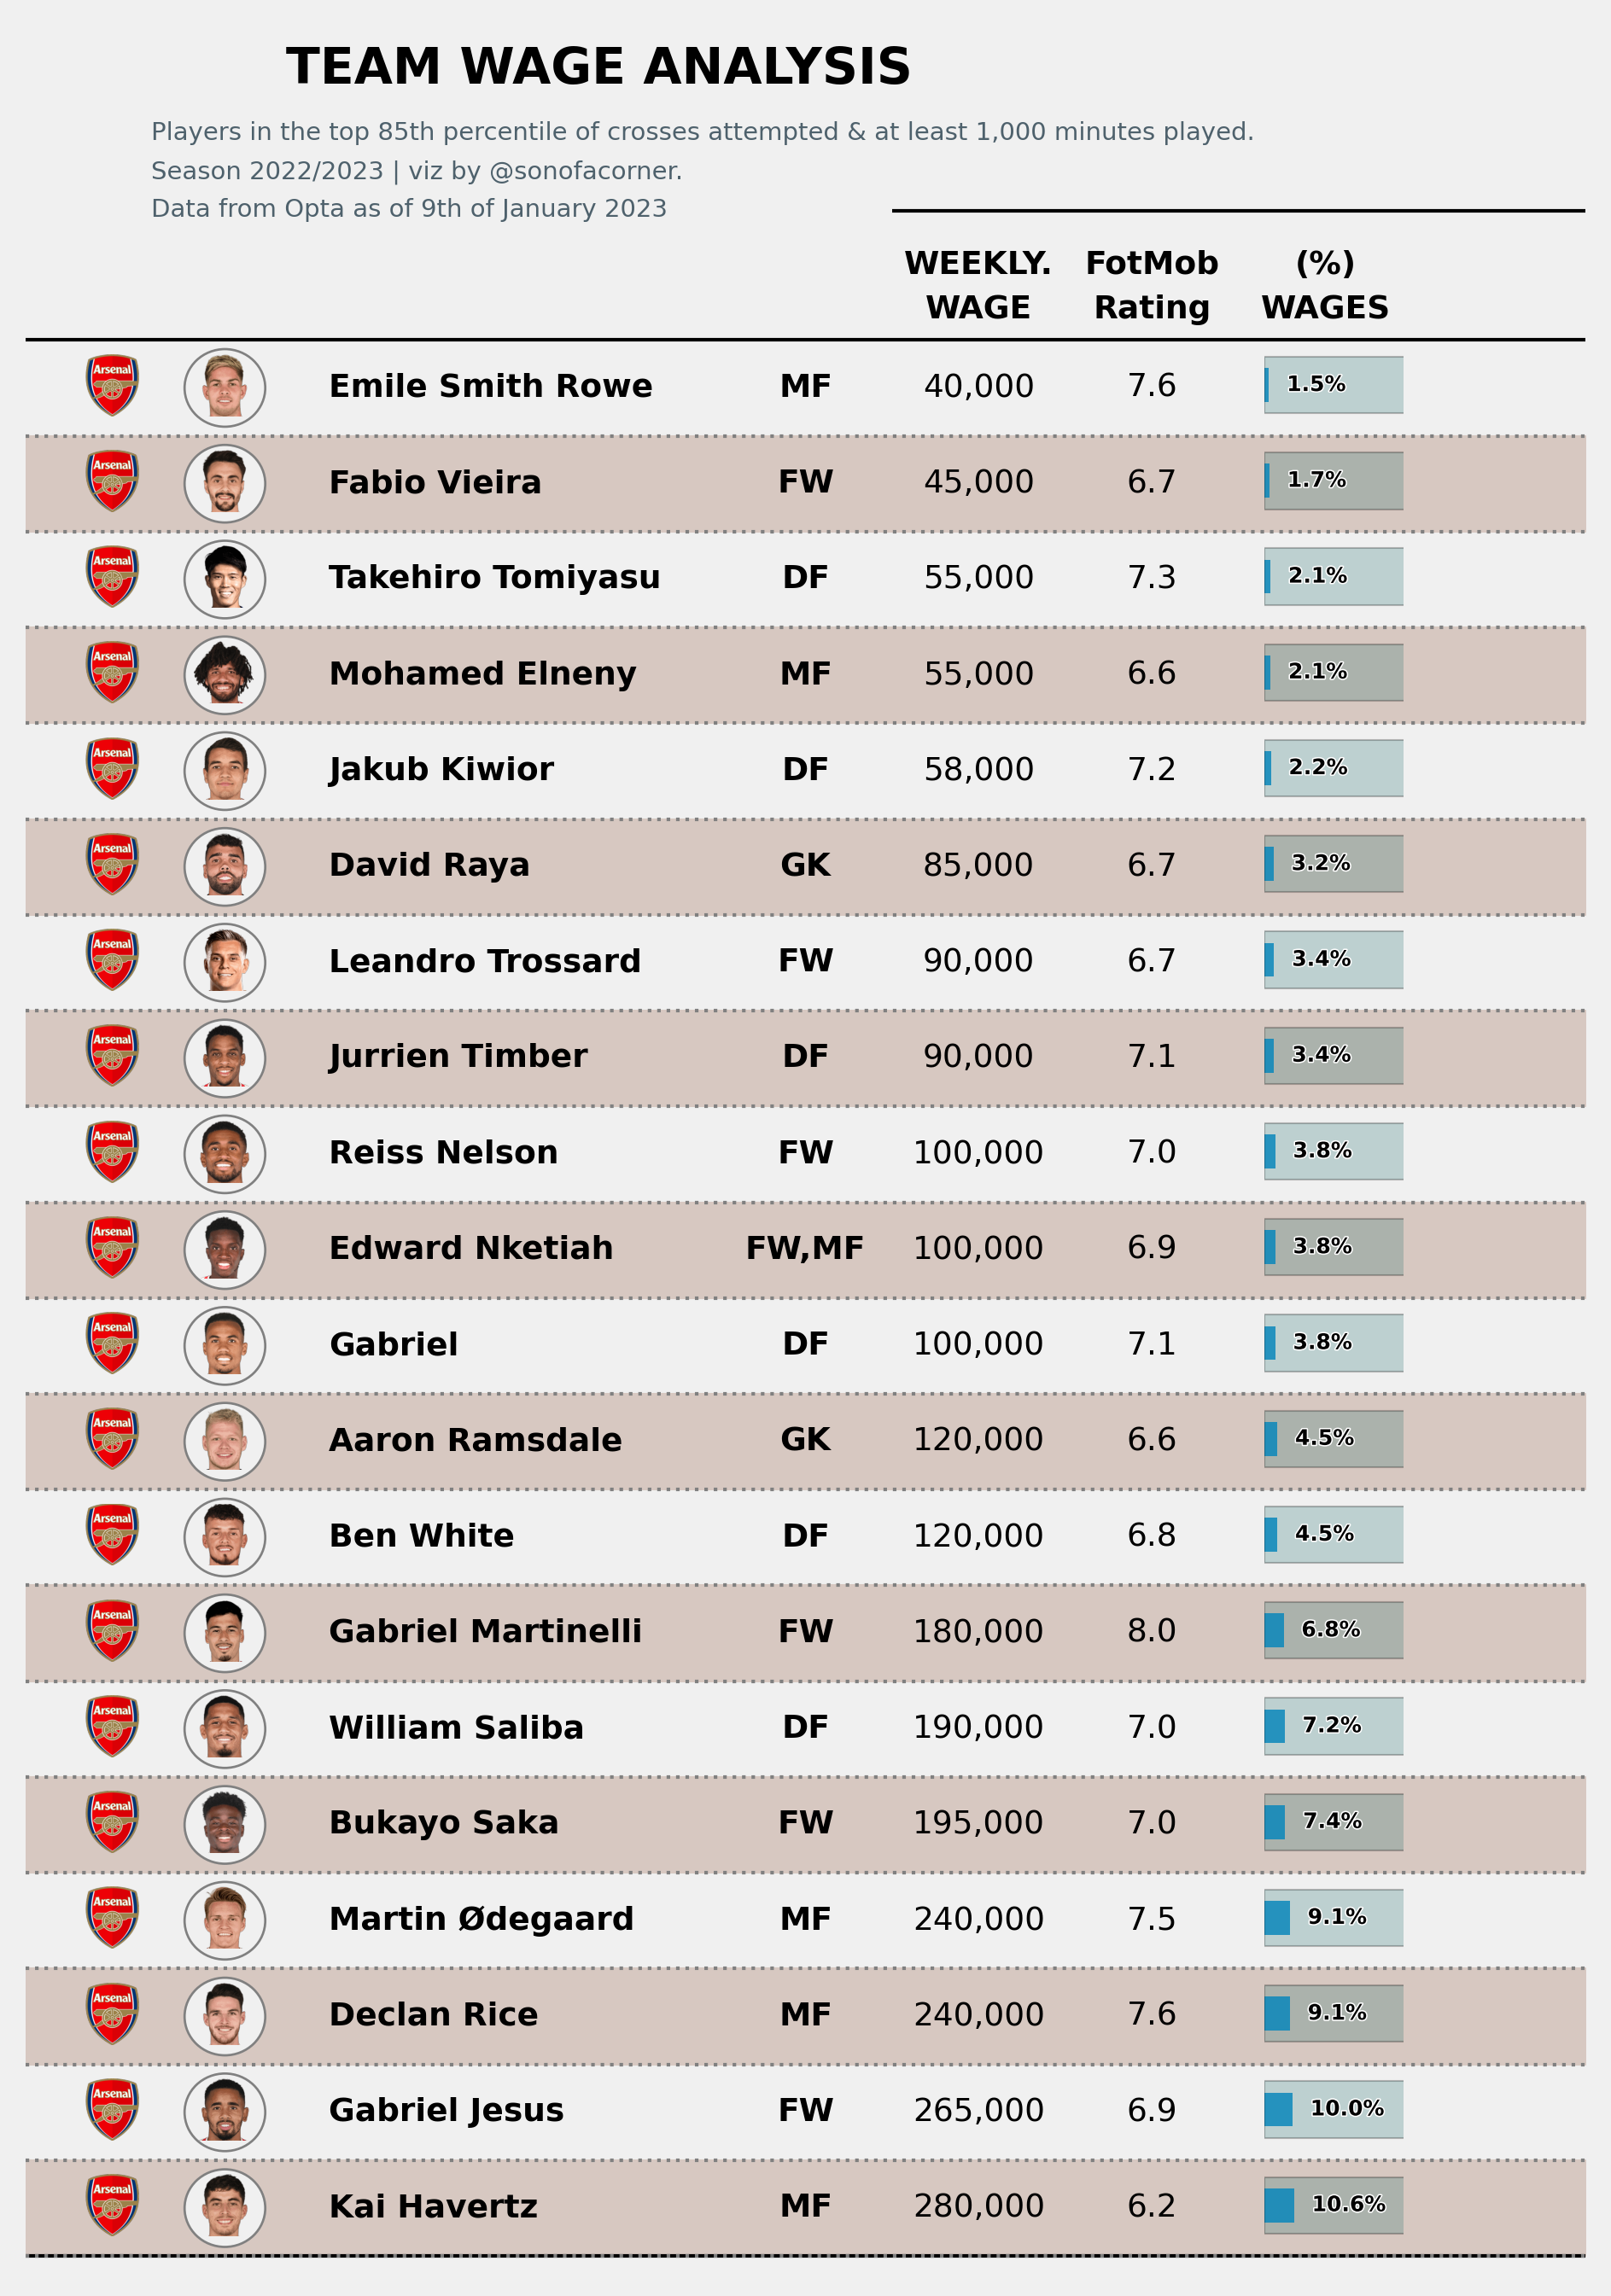

In [362]:
fig = plt.figure(figsize=(7,10), dpi=300)
ax = plt.subplot()

nrows = filtered_df.shape[0]
ncols = filtered_df.shape[1] - 3 # because I want to remove aprox. 3 columns from my DF

ax.set_xlim(0, ncols + 1)
ax.set_ylim(-.65, nrows + 1)

# calculate asymmetry of x and y axes: (I have no idea how this works)
x0, y0 = ax.transAxes.transform((0, 0)) # lower left in pixels
x1, y1 = ax.transAxes.transform((1, 1)) # upper right in pixes
dx = x1 - x0
dy = y1 - y0
maxd = max(dx, dy)
width = .35 * maxd / dx
height = .81 * maxd / dy

# Iterate
for y in range(0, nrows):
    # -- Club Logo
    bbox = Bbox.from_bounds(0, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_club_image_at_ax(filtered_df['team_id'].iloc[y], logo_ax)
    # -- Player picture
    circle = Ellipse((1.15, y), width, height, ec='grey', fc=fig.get_facecolor(), transform=ax.transData, lw=.65)
    bbox = Bbox.from_bounds(.65, y - .295, 1, .65)
    logo_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    draw_player_image_at_ax(filtered_df['player_id'].iloc[y], logo_ax)
    ax.add_artist(circle)
    # -- Player name
    ax_text(
        x=1.75, y=y,
        s=filtered_df['Name'].iloc[y],
        weight='bold', size=9,
        ha='left', va='center', ax=ax, family='Karla'
    )
    # -- Player position
    ax_text(
        x=4.5, y=y,
        s=filtered_df['Pos'].iloc[y],
        weight='bold', size=9,
        ha='center', va='center', ax=ax
    )
    # -- Minutes played
    ax_text(
        x=5.5, y=y,
        s=f"{filtered_df['new_pound_value'].iloc[y]:,.0f}",
        size=9,
        ha='center', va='center', ax=ax
    )
    # # -- Crosses
    ax_text(
        x=6.5, y=y,
        s=f"{filtered_df['ratings'].iloc[y]:,.1f}",
        size=9,
        ha='center', va='center', ax=ax
    )
    # # -- Battery Chart
    bbox = Bbox.from_bounds(7.15, y - .295, 0.8, .65)
    battery_ax = fig.add_axes([0, 0, 0, 0], axes_locator=BboxLocator(bbox, ax.transData))
    battery_ax.set_xlim(0,0.5)
    battery_ax.barh(y=.5, width=filtered_df['wage_contribution'].iloc[y], height=.3, alpha=.85)
    battery_ax.barh(y=.5, width=1, height=.5, alpha=.25, color='#287271', ec='black')
    text_ = battery_ax.annotate(
        xy=(filtered_df['wage_contribution'].iloc[y], .5),
        xytext=(5,0),
        textcoords='offset points',
        text=f"{filtered_df['wage_contribution'].iloc[y]:.1%}",
        ha='left', va='center',
        size=6, weight='bold'
    )
    text_.set_path_effects(
                [path_effects.Stroke(linewidth=.75, foreground="white"), 
                path_effects.Normal()]
            )
    battery_ax.set_axis_off()
    

# -- Draw border lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows - .5, nrows - .5], lw=1, color='black', zorder=3)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [-.5, -.5], lw=1, color='black', zorder=3)
for x in range(nrows):
    if x % 2 == 0:
        ax.fill_between(x=[ax.get_xlim()[0], ax.get_xlim()[1]], y1=x-.5, y2=x+.5, color='#d7c8c1', zorder=-1)
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x - .5, x - .5], lw=1, color='grey', ls=':', zorder=3)

ax.set_axis_off()


# -- Column titles
ax_text(
    x=5.5, y=nrows + .05,
    s='WEEKLY.\nWAGE',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)
ax_text(
    x=6.5, y=nrows + .05,
    s='FotMob\nRating',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)
ax_text(
    x=7.5, y=nrows + .05,
    s='(%)\nWAGES',
    size=9,
    ha='center', va='center', ax=ax,
    textalign='center', weight='bold'
)

ax.plot([5, ax.get_xlim()[1]], [nrows + .85, nrows + .85], lw=1, color='black', zorder=3)

fig_text(
    x = 0.4, y = .92, 
    s = "TEAM WAGE ANALYSIS",
    va = "bottom", ha = "center",
    fontsize = 14, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.15, y = .87, 
    s = "Players in the top 85th percentile of crosses attempted & at least 1,000 minutes played.\nSeason 2022/2023 | viz by @sonofacorner.\nData from Opta as of 9th of January 2023",
	va = "bottom", ha = "left",
	fontsize = 7, color = "#4E616C", font = "DM Sans"
)

# plt.savefig(
# 	"figures/01092023_epl_crosses.png",
# 	dpi = 600,
# 	facecolor = "#EFE9E6",
# 	bbox_inches="tight",
#     edgecolor="none",
# 	transparent = False
# )

# plt.savefig(
# 	"figures/01092023_epl_crosses_tr.png",
# 	dpi = 600,
# 	facecolor = "none",
# 	bbox_inches="tight",
#     edgecolor="none",
# 	transparent = True
# )

In [20]:
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import scipy.stats as stats

filtered_df['new_pound_value_2'] = filtered_df['new_pound_value']/1000

filtered_df['zscore'] = stats.zscore(filtered_df['new_pound_value_2'])*1 + stats.zscore(filtered_df['ratings'])*1
filtered_df['annotated'] = [True if x > filtered_df['zscore'].quantile(0) else False for x in filtered_df['zscore']]


def pound_formatter(x, pos):
    return f'£{x/1000:.0f}K'

In [21]:
filtered_df

,Unnamed: 0,Name,Nation,Pos,Age,new_pound_value,URL,ratings,team_id,player_id,wage_contribution,new_pound_value_2,zscore,annotated
272,0,Kai Havertz,de GER,MF,24.0,280000,https://www.fotmob.com/players/749736/kai-havertz,7.08,9825,749736,0.099715,280.0,1.995900,True
273,1,Gabriel Jesus,br BRA,FW,26.0,265000,https://www.fotmob.com/players/576165/gabriel-...,7.13,9825,576165,0.094373,265.0,1.929961,True
274,2,Declan Rice,eng ENG,MF,24.0,240000,https://www.fotmob.com/players/654096/declan-rice,7.65,9825,654096,0.085470,240.0,3.002668,True
275,3,Martin Ødegaard,no NOR,MF,24.0,240000,https://www.fotmob.com/players/534670/martin-o...,7.61,9825,534670,0.085470,240.0,2.894337,True
276,4,Thomas Partey,gh GHA,MF,30.0,200000,https://www.fotmob.com/players/434325/thomas-p...,6.59,9825,434325,0.071225,200.0,-0.405021,True
277,5,Bukayo Saka,eng ENG,FW,21.0,195000,https://www.fotmob.com/players/961995/bukayo-saka,6.59,9825,961995,0.069444,195.0,-0.472138,True
279,7,Gabriel Martinelli,br BRA,FW,22.0,180000,https://www.fotmob.com/players/1021586/gabriel...,7.68,9825,1021586,0.064103,180.0,2.278508,True
280,8,Oleksandr Zinchenko,ua UKR,DF,26.0,150000,https://www.fotmob.com/players/623621/oleksand...,6.74,9825,623621,0.053419,150.0,-0.669955,True
281,9,Ben White,eng ENG,DF,25.0,120000,https://www.fotmob.com/players/776151/ben-white,6.60,9825,776151,0.042735,120.0,-1.451814,True
282,10,Aaron Ramsdale,eng ENG,GK,25.0,120000,https://www.fotmob.com/players/746395/aaron-ra...,6.75,9825,746395,0.042735,120.0,-1.045576,True


findfont: Font family ['DM Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['DM Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Karla'] not found. Falling back to DejaVu Sans.


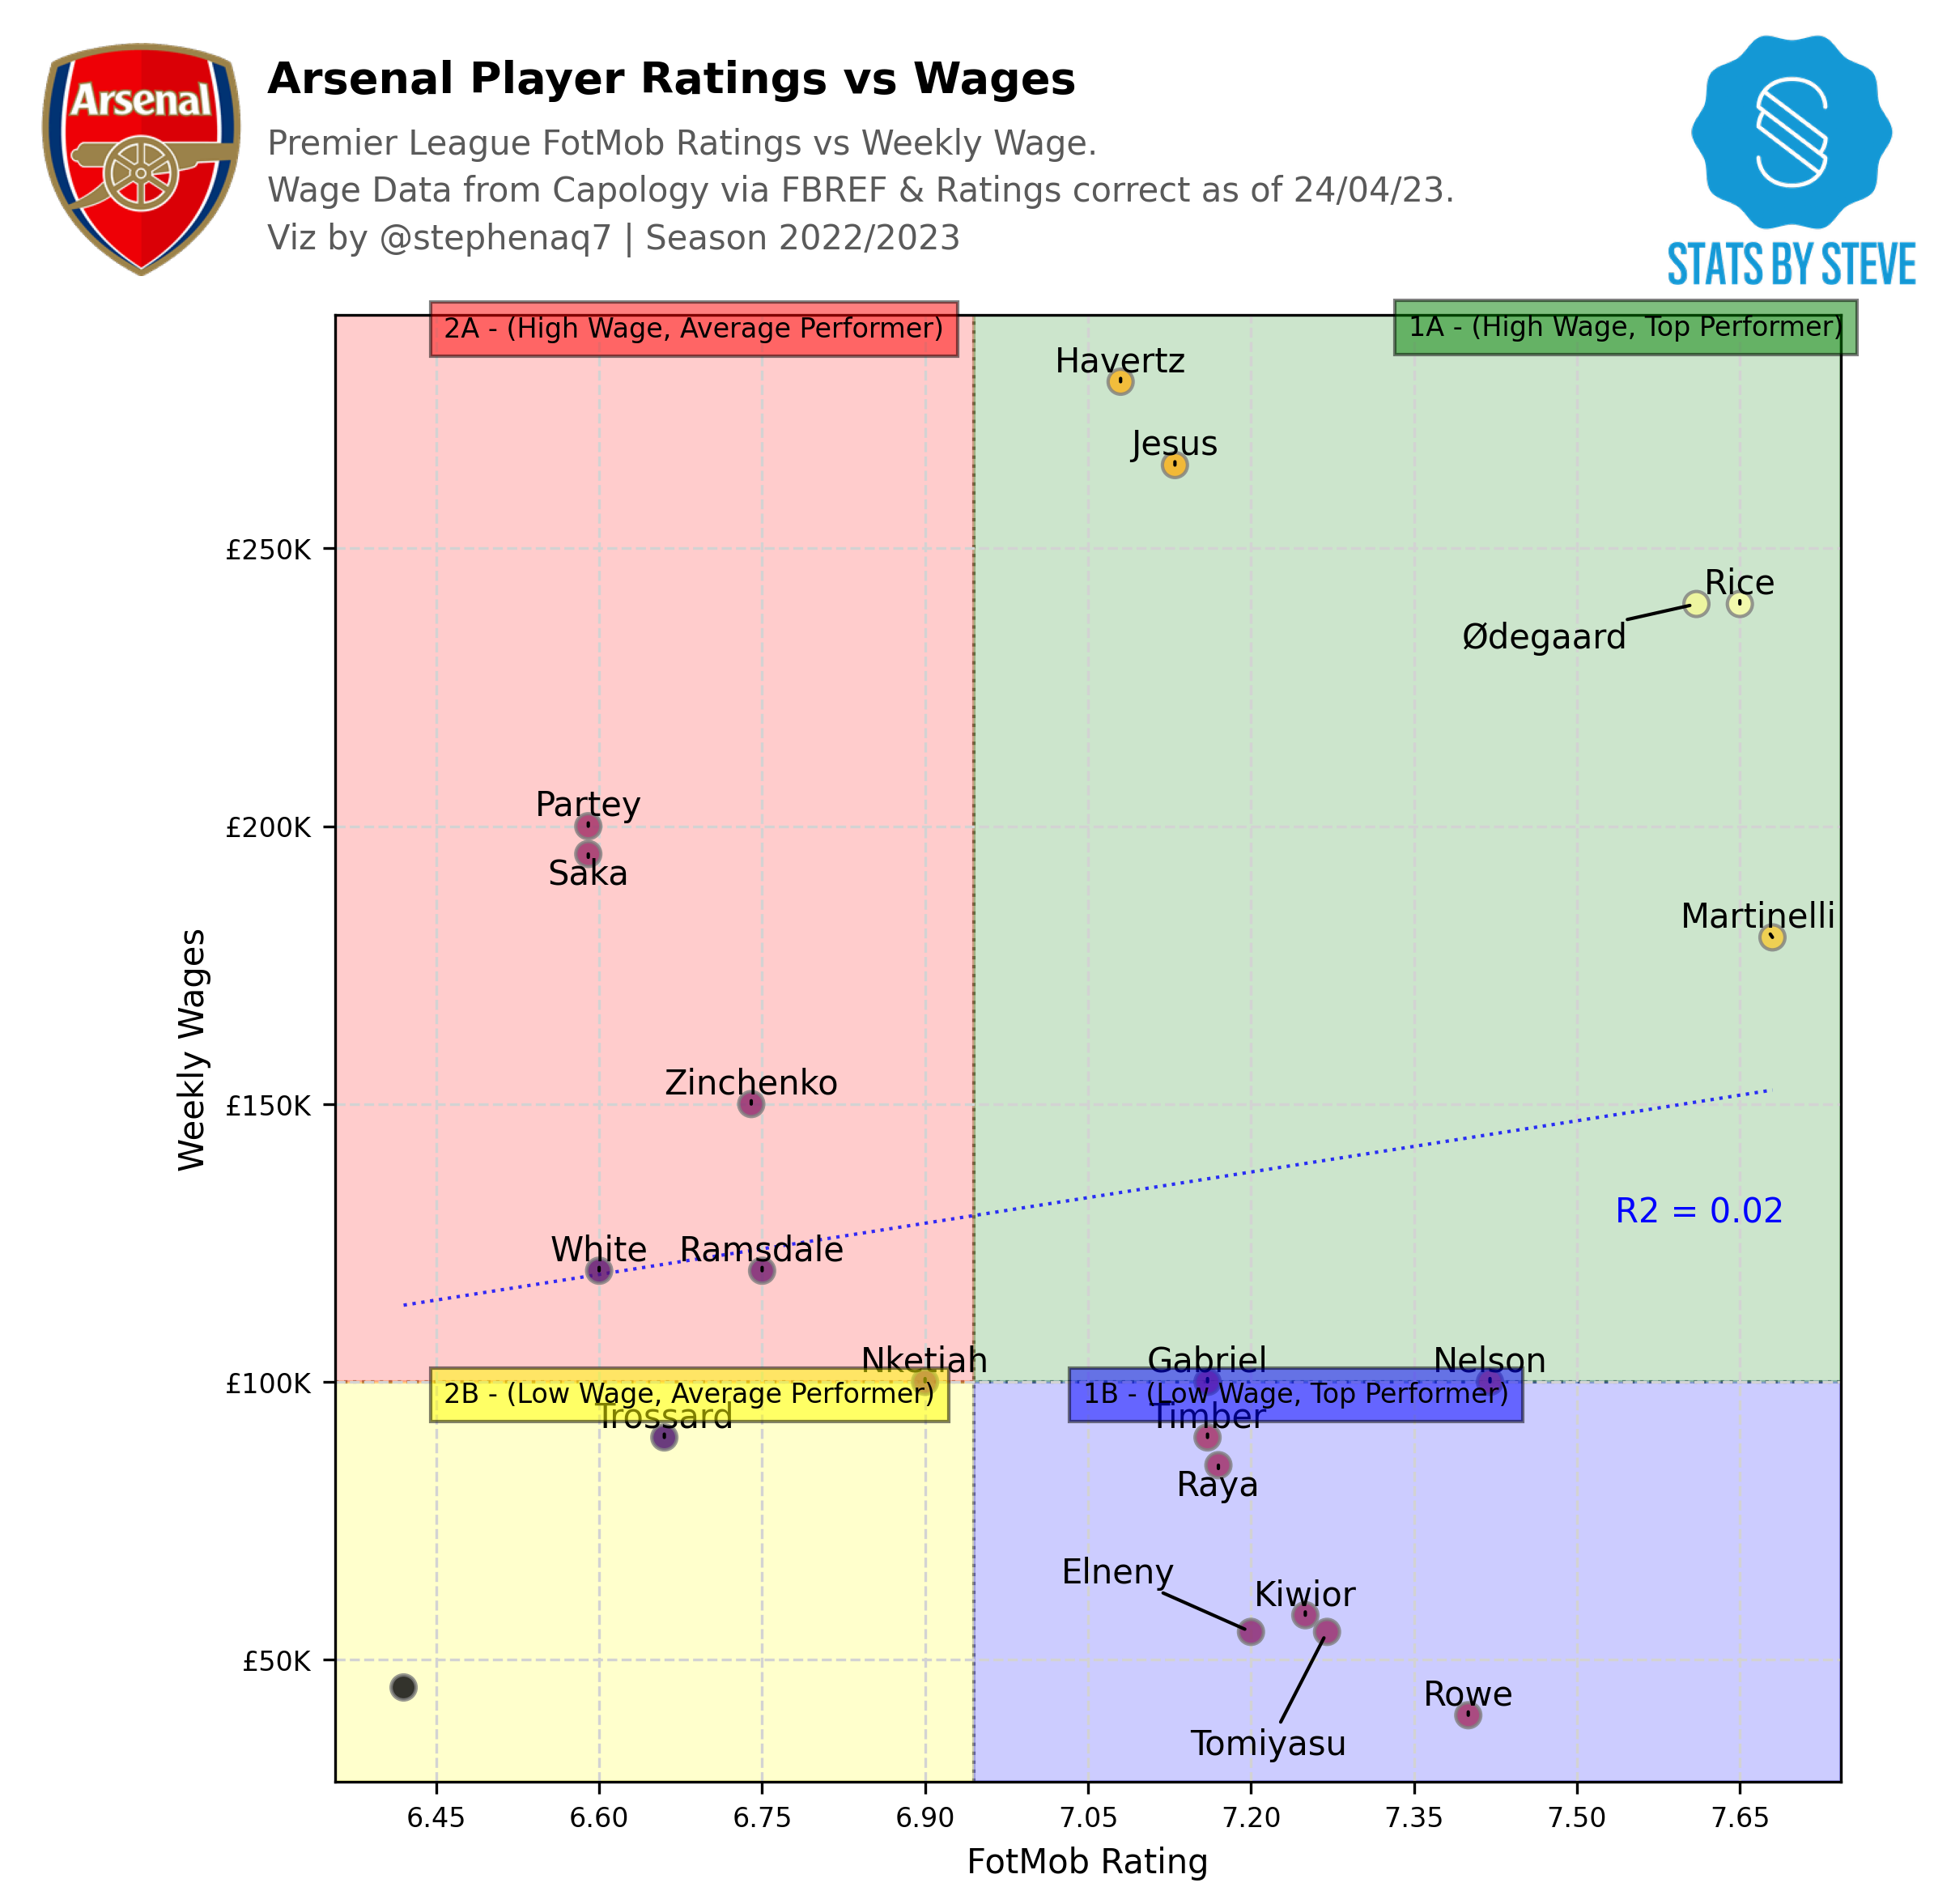

In [22]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.image as image
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
from adjustText import adjust_text
import math

# Define a custom formatter for y-axis tick labels
max_ = max(abs(filtered_df['new_pound_value_2'].min()), filtered_df['new_pound_value_2'].max())

fig = plt.figure(figsize=(8, 8), dpi=300)
ax = plt.subplot()
ax.grid(visible=False, ls='--', color='lightgrey')

# Define quadrants based on median values of 'ratings' and 'new_pound_value_2'
median_ratings = ((filtered_df['ratings'].median())*0.97)
median_wages = filtered_df['new_pound_value_2'].median()

# Plot scatter points for each quadrant
scatter = ax.scatter(
    filtered_df['ratings'], filtered_df['new_pound_value_2'],
    c=filtered_df['zscore'], cmap='inferno',
    zorder=3, ec='grey', s=55, alpha=0.8)

texts = []
annotated_df = filtered_df[filtered_df['annotated']].reset_index(drop=True)
for index in range(annotated_df.shape[0]):
    # Extract last name from 'Name' column by splitting on space and taking the last element
    last_name = annotated_df['Name'].iloc[index].split()[-1]
    texts += [
        ax.text(
            x=annotated_df['ratings'].iloc[index], y=annotated_df['new_pound_value_2'].iloc[index],
            s=f"{last_name}",
            color='black',
            family='DM Sans', weight='light', fontsize=10 
        )
    ]

# Use adjust_text function to move overlapping texts
adjust_text(texts, force_text=(2, 2),
            arrowprops=dict(arrowstyle='-',color='black'),
            autoalign='y',
            only_move={'points':'y'})


# Add dotted line to separate quadrants
ax.axvline(median_ratings, linestyle='dotted', color='grey', lw=1, zorder=0)
ax.axhline(median_wages, linestyle='dotted', color='grey', lw=1, zorder=0)


# Set x-axis and y-axis limits to be equal
ax.set_xlim([ax.get_xlim()[0], ax.get_xlim()[1]])
ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1]])

# Fill quadrants with transparent colors
ax.fill_between(
    [ax.get_xlim()[0], median_ratings],
    ax.get_ylim()[0], median_wages,
    color='yellow', alpha=0.2
)
ax.fill_between(
    [median_ratings, ax.get_xlim()[1]],
    ax.get_ylim()[0], median_wages,
    color='blue', alpha=0.2
)
ax.fill_between(
    [ax.get_xlim()[0], median_ratings],
    median_wages, ax.get_ylim()[1],
    color='red', alpha=0.2
)
ax.fill_between(
    [median_ratings, ax.get_xlim()[1]],
    median_wages, ax.get_ylim()[1],
    color='green', alpha=0.2
)

ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=False, prune='both'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'£{x:.0f}K'))
ax.tick_params(axis='both', labelsize=8)  # Updated fontsize to 8

ax.set_ylabel('Weekly Wages', fontsize=10)  # Set y-axis label with font size
ax.set_xlabel('FotMob Rating', fontsize=10)

ax.text(ax.get_xlim()[0] + 0.1, ax.get_ylim()[1] - 0.1,
        '2A - (High Wage, Average Performer)',
        bbox=dict(facecolor='red', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')
ax.text(ax.get_xlim()[0] + 0.1, median_wages + 0.1,
        '2B - (Low Wage, Average Performer)',
        bbox=dict(facecolor='yellow', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')
ax.text(median_ratings + 0.4, ax.get_ylim()[1] + 0.15,
        '1A - (High Wage, Top Performer)',
        bbox=dict(facecolor='green', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')
ax.text(median_ratings + 0.1, median_wages + 0.1,
        '1B - (Low Wage, Top Performer)',
        bbox=dict(facecolor='blue', alpha=0.5),
        horizontalalignment='left', verticalalignment='top',
        fontsize=8, color='black')

coefficients = np.polyfit(filtered_df['ratings'], filtered_df['new_pound_value_2'], 1)
p = np.poly1d(coefficients)
x_regression = np.linspace(np.min(filtered_df['ratings']), np.max(filtered_df['ratings']), 100)
y_regression = p(x_regression)

# Plot the regression line
ax.plot(x_regression, y_regression, c='b', label='Regression Line', linewidth=1, linestyle=':', alpha=0.8)

# Add R2 value as text
r2 = np.corrcoef(filtered_df['ratings'], filtered_df['new_pound_value_2'])[0, 1] ** 2  # Calculate R2 value
ax.text(0.85, 0.4, f'R2 = {r2:.2f}', transform=ax.transAxes, ha='left', va='top',fontsize=10,color='blue')





ax3 = fig.add_axes([0.78, 0.89, 0.19, 0.14])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/logo_transparent_background.png')
ax3.imshow(img)




fig_text(
    x=0.09, y=.99,
    s="Arsenal Player Ratings vs Wages",
    va="bottom", ha="left",
    fontsize= 13, color="black", font="DM Sans", weight="bold"
)
fig_text(
    x=0.09, y=0.91,
    s="Premier League FotMob Ratings vs Weekly Wage.\nWage Data from Capology via FBREF & Ratings correct as of 24/04/23.\nViz by @stephenaq7 | Season 2022/2023",
    va="bottom", ha="left",
    fontsize=10, color="#5A5A5A", font="Karla"
)
fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"

logo_ax = fig.add_axes([-0.08, .90, 0.21, 0.12], zorder=1)
club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{t_id}.png"))
logo_ax.imshow(club_icon)
logo_ax.axis("off")


plt.show()


In [329]:
team_names = pd.read_csv("CSVs/fotmob_epl_team_ids.csv")
wage_dist = pd.merge(merged_df, team_names, on='team_id')
cols = ["Name", "Age", "new_pound_value", "team_id", "team"]
wage_dist = wage_dist[cols]

def remove_duplicates(df):
    df.drop_duplicates(subset=["Name"], keep="last", inplace=True)
    return df

wage_dist = remove_duplicates(wage_dist)

In [330]:
def create_wage_bins(df):
    bin_labels = ["<£10k", "£10k-£50k", "£50k-£80k", "£80k-£100k", "£100k-£150k", "£150k-£200k", "£200k+"]
    bin_edges = [0, 10000, 50000, 80000, 100000, 150000, 200000, 500000]
    
    df["Wage_Bin"] = pd.cut(df["new_pound_value"], bins=bin_edges, labels=bin_labels, include_lowest=True)
    df.dropna(subset=["Wage_Bin"], inplace=True)
    bin_counts = df.groupby("Wage_Bin")["team"].nunique()
    df["Count"] = df["Wage_Bin"].map(bin_counts)
    return df

wages_viz = create_wage_bins(wage_dist)

In [331]:
wages_viz.to_csv("wage_viz.csv")

In [332]:
wage_bill = wages_viz.groupby(['team','team_id' ])['new_pound_value'].sum() 
wage_bill = pd.DataFrame(wage_bill).reset_index()
wage_bill = wage_bill[['team','new_pound_value']].sort_values(by='new_pound_value', ascending=False)

In [333]:
aggregated_df = wages_viz.groupby(['team', 'Wage_Bin']).size().reset_index(name='Count')

In [334]:
all_bins = ["<£10k", "£10k-£50k", "£50k-£80k", "£80k-£100k", "£100k-£150k", "£150k-£200k", "£200k+"]

# Get unique teams and team_ids
unique_teams = aggregated_df['team'].unique()

result_dfs = []
for team in unique_teams:

    team_data = aggregated_df[(aggregated_df['team'] == team)]
    team_combinations = pd.DataFrame({'Wage_Bin': all_bins})
    merged_data = team_combinations.merge(team_data, on='Wage_Bin', how='left').fillna(0)
    merged_data['team'] = team
    result_dfs.append(merged_data)

aggregated_df = pd.concat(result_dfs, ignore_index=True)
aggregated_df = aggregated_df[['team', 'Wage_Bin', 'Count']].sort_values(by=['team'])


In [335]:
team_ids = pd.read_csv("CSVs/fotmob_epl_team_ids.csv")
team_ids = team_ids[['team','team_id']]

In [336]:
aggregated_df = pd.merge(aggregated_df,team_ids, on='team', how='left')
aggregated_df = pd.merge(aggregated_df,wage_bill, on='team', how='left')

In [337]:
wage_bin_order = ["<£10k", "£10k-£50k", "£50k-£80k", "£80k-£100k", "£100k-£150k", "£150k-£200k", "£200k+"]

# Set Wage_Bin column as ordered categorical to maintain the specified order
aggregated_df['Wage_Bin'] = pd.Categorical(aggregated_df['Wage_Bin'], categories=wage_bin_order, ordered=True)

# Sort the DataFrame by team and Wage_Bin
aggregated_df = aggregated_df.sort_values(by=['team', 'Wage_Bin'])

In [340]:
wage_bill_rank = pd.merge(wage_bill,team_ids, on='team', how='left')

In [341]:
team_list = list(wage_bill_rank.team_id.unique())

In [342]:
colors = [
    '#302028', '#206890', '#085898', '#375196', '#FF3333', '#085098', '#005898',
    '#330000', '#005090', '#007838', '#0C2044', '#0044CC', '#FF6600', '#FF3399',
    '#00CC99', '#9900FF', '#FF00CC', '#66FF33', '#FFCC00', '#3399FF'
]
color_dict = dict(zip(team_list,colors))

In [343]:
aggregated_df["teamColor"] = aggregated_df['team_id'].map(color_dict)

In [344]:
aggregated_df

,team,Wage_Bin,Count,team_id,new_pound_value,teamColor
0,Arsenal,<£10k,1.0,9825,3193000,#085898
1,Arsenal,£10k-£50k,2.0,9825,3193000,#085898
2,Arsenal,£50k-£80k,4.0,9825,3193000,#085898
3,Arsenal,£80k-£100k,6.0,9825,3193000,#085898
4,Arsenal,£100k-£150k,4.0,9825,3193000,#085898
5,Arsenal,£150k-£200k,4.0,9825,3193000,#085898
6,Arsenal,£200k+,4.0,9825,3193000,#085898
12,Aston Villa,<£10k,0.0,10252,2087885,#005898
10,Aston Villa,£10k-£50k,4.0,10252,2087885,#005898
11,Aston Villa,£50k-£80k,7.0,10252,2087885,#005898


In [345]:
def plot_barchart_wages(ax, team_id, color, labels_x = False, labels_y = False):
    '''
    This function plots the bar chart showing the proportion
    of goals and xG created by each side in a specific interval of time.

    Args:
        ax (object): the matplotlib ax object
        teamId (int): the Fotmob team id
        color (str): the HEX color string to use for the plot
    '''

    global aggregated_df

    data = aggregated_df.copy()
    data = data[data["team_id"] == team_id].reset_index(drop = True)

    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines["top"].set_visible(False)

    # Set border properties for the subplot
    border_width = 0.5
    border_color = 'black'

    ax.spines['top'].set_linewidth(border_width)  # Top border width
    ax.spines['top'].set_color(border_color)  # Top border color

    ax.spines['bottom'].set_linewidth(border_width)  # Bottom border width
    ax.spines['bottom'].set_color(border_color)  # Bottom border color

    ax.spines['left'].set_linewidth(border_width)  # Left border width
    ax.spines['left'].set_color(border_color)  # Left border color

    ax.spines['right'].set_linewidth(border_width)  # Right border width
    ax.spines['right'].set_color(border_color)  # Right border color


    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)

    ax.grid(True, lw = 1, ls = '--', color = "lightgrey")
    
    ax.bar(
        data.index,
        data["Count"],
        color = color,
        alpha = 0.6,
        zorder = 3,
        width = .65
    )
    ax.bar(
        data.index,
        data["Count"],
        color = color,
        width = 0.25,
        zorder =3
    )




    ax.set_xticks(data.index)
    if labels_x:
        labels = ["<£10k", "£10k-£50k", "£50k-£80k", "£80k-£100k", "£100k-£150k", "£150k-£200k", "£200k+"]
        ax.set_xticklabels(labels, fontsize=9, rotation=45, ha='right', va='top')
    else:
        ax.set_xticklabels([])

    ax.set_ylim(0,30)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

    if labels_y == False:
        ax.set_yticklabels([])




    # ---- Nice touches to the viz
    ax.plot([2.5, 2.5], [0, .5], color = "gray", lw = 1.15, ls = "--")

    for index, height in enumerate(data["Count"]):
        if height != 0:
            text_ = ax.annotate(
                xy = (index, height),
                text = f"{height:.0f}",
                xytext = (0, 7.5),
                textcoords = "offset points",
                ha = "center",
                va = "center",
                size = 10,
                weight = "bold",
                color = "black"
            )
            text_.set_path_effects(
                [path_effects.Stroke(linewidth=1.75, foreground="white"), path_effects.Normal()])
        else:
            text_ = ax.annotate(
                xy = (index, height),
                text = " ",
                xytext = (0, 7.5),
                textcoords = "offset points",
                ha = "center",
                va = "center",
                size = 10,
                weight = "bold",
                color = "black"
            )
            text_.set_path_effects(
                [path_effects.Stroke(linewidth=1.75, foreground="white"), path_effects.Normal()]
        
            )

    return ax


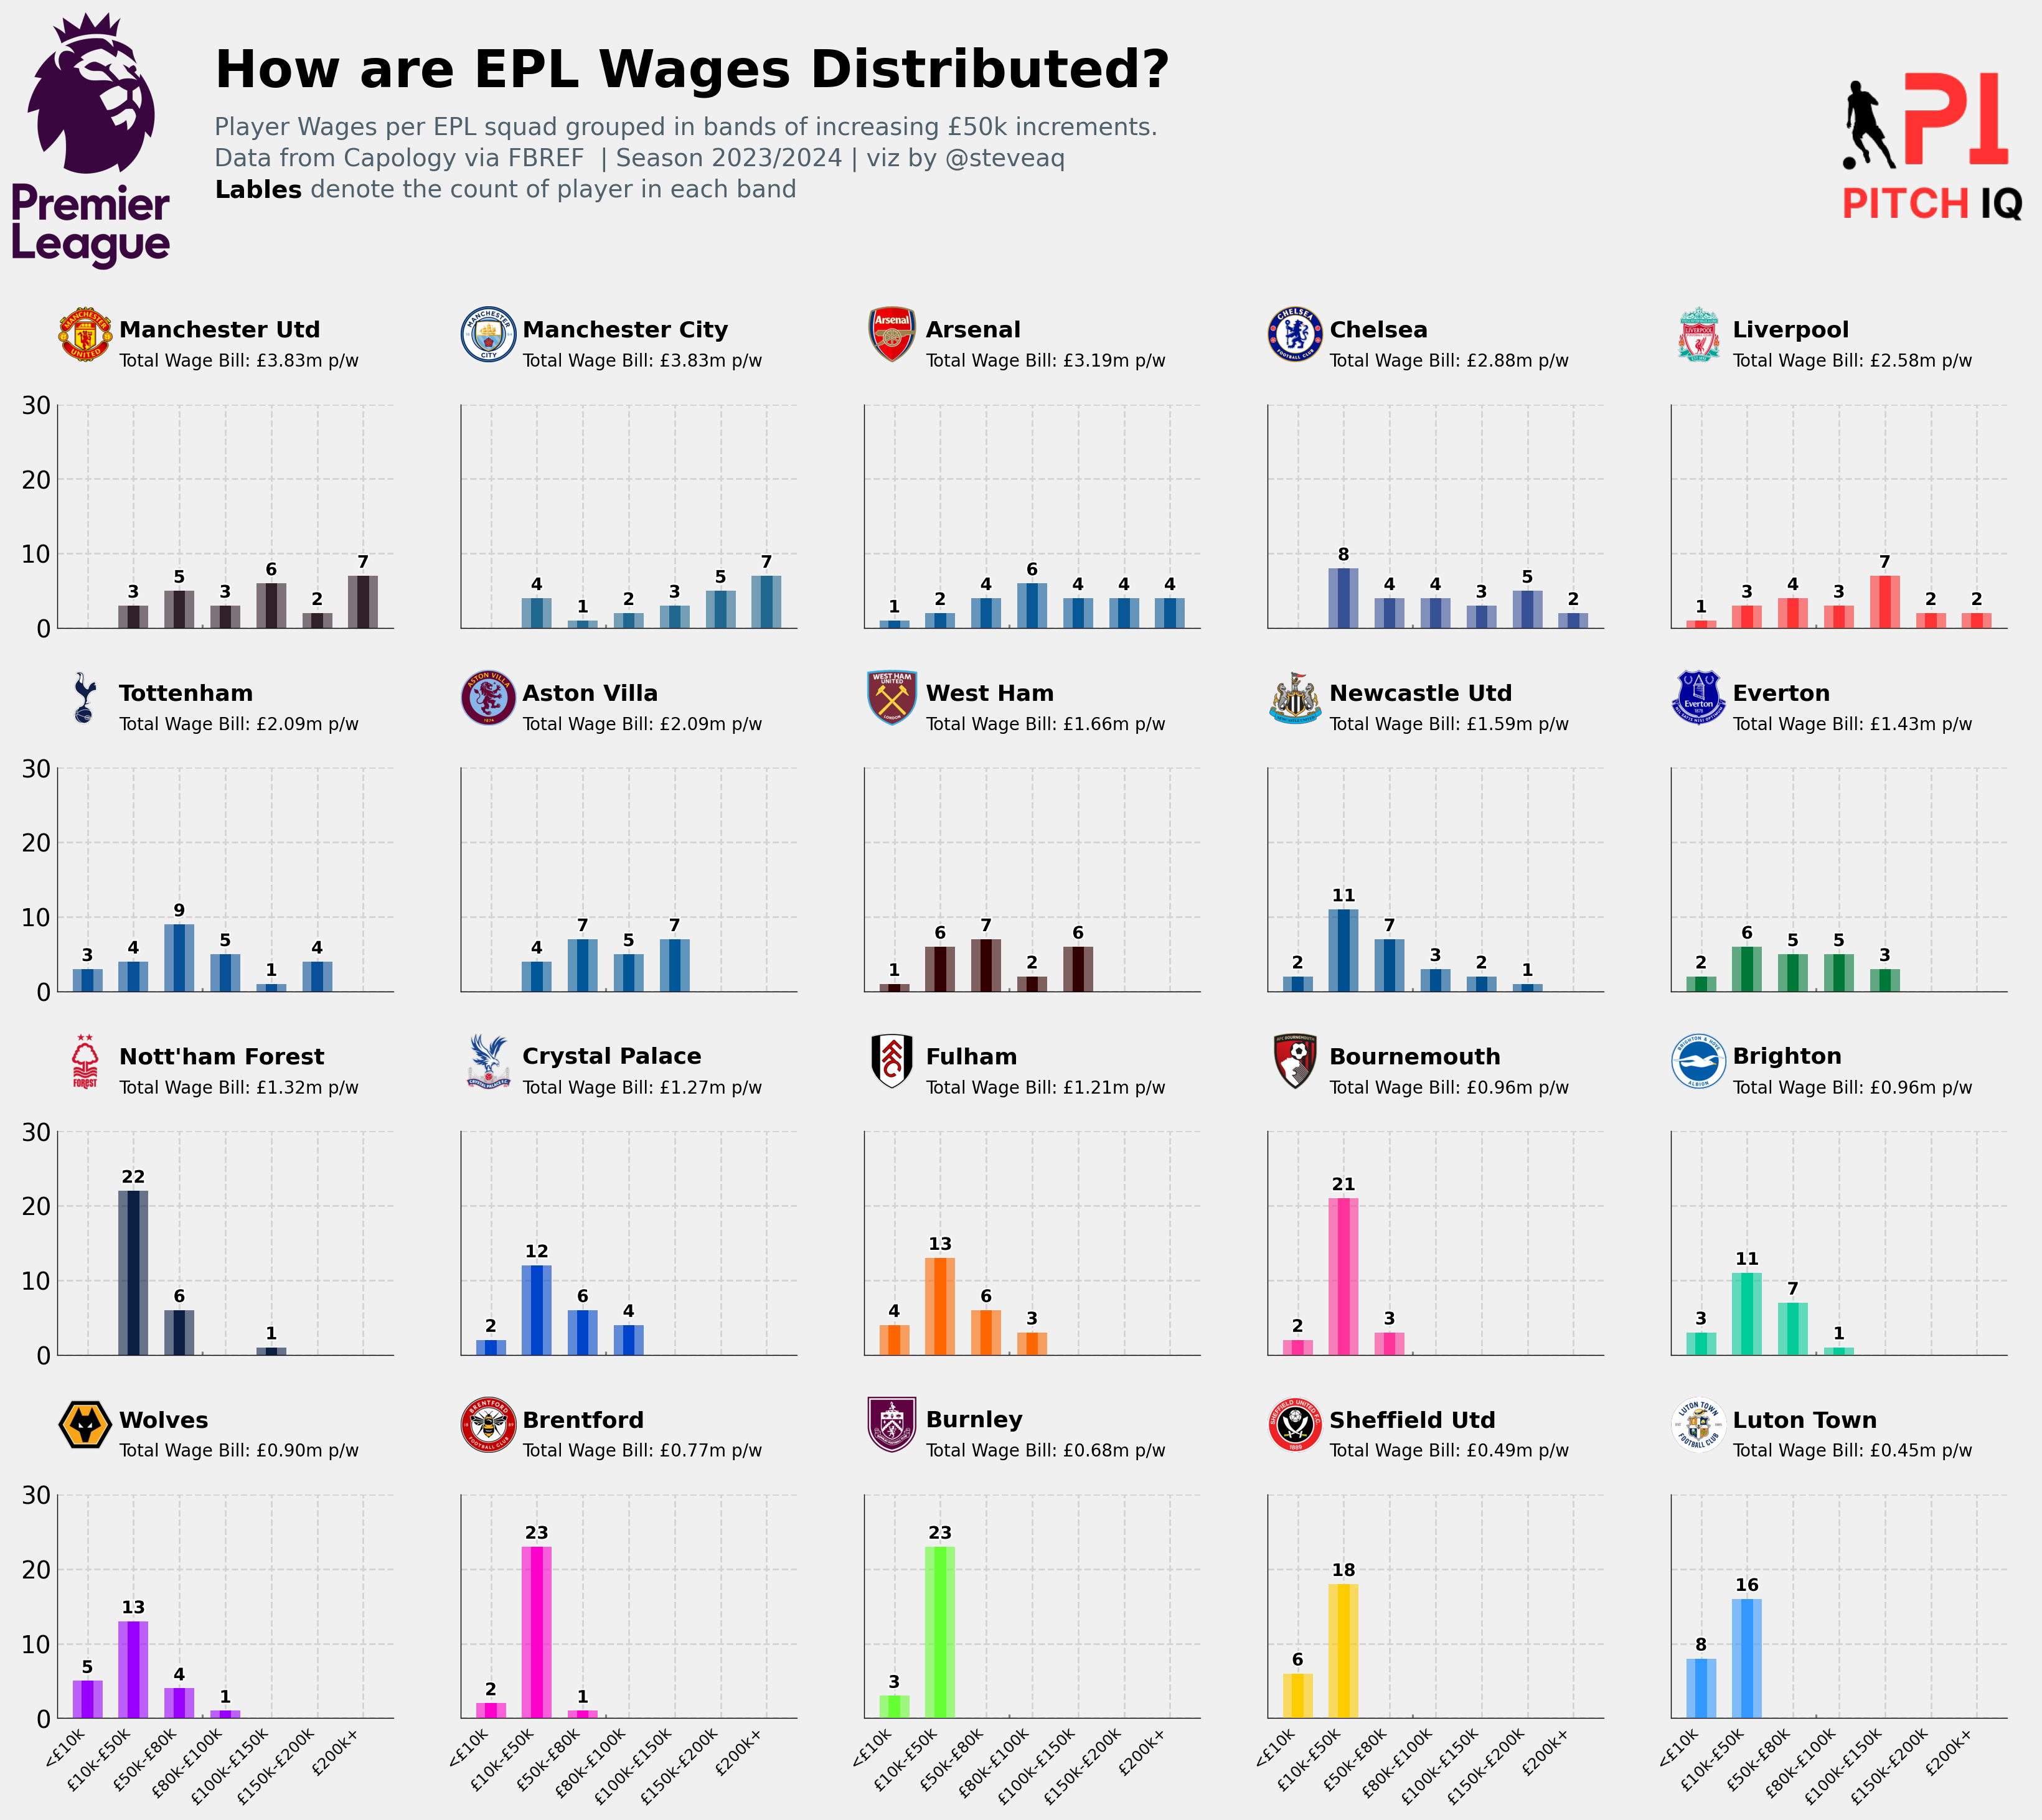

In [347]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
from matplotlib import rcParams
from highlight_text import ax_text, fig_text
import pandas as pd

from PIL import Image
import urllib
import os
style.use('fivethirtyeight')


df = aggregated_df
fig = plt.figure(figsize=(18, 14), dpi = 200)
nrows = 8
ncols = 5
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig, 
    height_ratios = [(1/nrows)*2. if x % 2 != 0 else (1/nrows)/2. for x in range(nrows)], hspace = 0.3
)

teams = team_list

plot_counter = 0
logo_counter = 0
for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col]
            )

            teamId = teams[plot_counter]
            teamcolor = df[df["team_id"] == teamId]["teamColor"].iloc[0]

            if col == 0:
                labels_y = True
            else:
                labels_y = False
            
            if row == nrows - 1:
                labels_x = True
            else:
                labels_x = False
            
            plot_barchart_wages(ax, teamId, teamcolor, labels_x, labels_y)           

            plot_counter += 1
        
        else:

            teamId = teams[logo_counter]
            teamName = df[df["team_id"] == teamId]["team"].iloc[0]

            wages = df[df["team_id"] == teamId]["new_pound_value"].sum()/7000000


            fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
            logo_ax = plt.subplot(
                gspec[row,col],
                anchor = "NW", facecolor = "#EFE9E6"
            )
            club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{teamId:.0f}.png"))
            logo_ax.imshow(club_icon)
            logo_ax.axis("off")

            # # Add the team name
            ax_text(
                x = 1.1, 
                y = 0.76,
                s = f"{teamName}",
                ax = logo_ax, 
                weight = "bold", 
                font = "Karla", 
                ha = "left", 
                size = 13, 
                annotationbbox_kw = {"xycoords":"axes fraction"}
            )

            # # Add the subtitles for each side
            ax_text(
                x = 1.1,
                y = 0.18,
                s = f"Total Wage Bill: £{wages:.2f}m p/w",
                ax = logo_ax, 
                weight = "normal", 
                font = "Karla", 
                ha = "left", 
                size = 10, 
                annotationbbox_kw = {"xycoords":"axes fraction"}
            )

            logo_counter += 1


fig_text(
    x = 0.15, y = 1, 
    s = "How are EPL Wages Distributed?",
    va = "bottom", ha = "left",
    fontsize = 30, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.15, y = .94, 
    s = "Player Wages per EPL squad grouped in bands of increasing £50k increments.\nData from Capology via FBREF  | Season 2023/2024 | viz by @steveaq\n<Lables> denote the count of player in each band",
    highlight_textprops=[{"weight": "bold", "color": "black"}],
	va = "bottom", ha = "left",
	fontsize = 14, color = "#4E616C", font = "Karla"
)

ax2 = fig.add_axes([0.06, 0.55, 0.07, 0.85])
ax2.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/Images/premier-league-2-logo.png')
ax2.imshow(img)


### Add Stats by Steve logo
ax3 = fig.add_axes([0.87, 0.55, 0.09, .85])
ax3.axis('off')
img = image.imread('/Users/stephenahiabah/Desktop/GitHub/Webs-scarping-for-Fooball-Data-/outputs/piqmain.png')
ax3.imshow(img)

